# Kernel, k-nearest neighbours and local linear regression

This small notebook touches on three different types of regressions that are useful to know about. The main difference from most of the other methods we have considered is that the regression methods discussed here give higher weight to points close to the point we want to estimate the function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astroML.linear_model import NadarayaWatson
import statsmodels.api as sm
import scipy.stats as stats
%matplotlib inline

In [2]:
sns.set_context('talk')
sns.set_style('whitegrid', {"grid.color": ".95", 'grid.linestyle': u'-'})

In [3]:
def make_fake_data():
    """
    Create some data from a sine curve.
    """
    
    np.random.seed(15)
    
    n_samples = 7
    
    x = np.random.uniform(-1, 1.5, 10)*np.pi
    x.sort()
    
    y = np.sin(x)
    
    # And finally add some noise
    dy = 1.0/3.0
    y = y + np.random.normal(0, dy, len(y))
    
    return x, y, dy

def plot_a_fit(x, y, xest, yest, include_true=False):
    """
    Plot the result of a fit to the fake data. This is put in as a function
    to speed things up below.
    """
    
    plt.scatter(x, y, 150, marker='.')
    plt.plot(xest, yest, '-', color='#00aaff')
    
    if include_true:
        plt.plot(xest, np.sin(xest), '--', color='#999999')

In [4]:
x, y, dy = make_fake_data()
xplot = np.linspace(np.min(x), np.max(x), 1000)
yplot = np.sin(xplot)

For the fitting routines the X values typically have to insert an extra dimension to have the right dimensionality:

In [5]:
X = x[:, np.newaxis]
Xplot = xplot[:, np.newaxis]

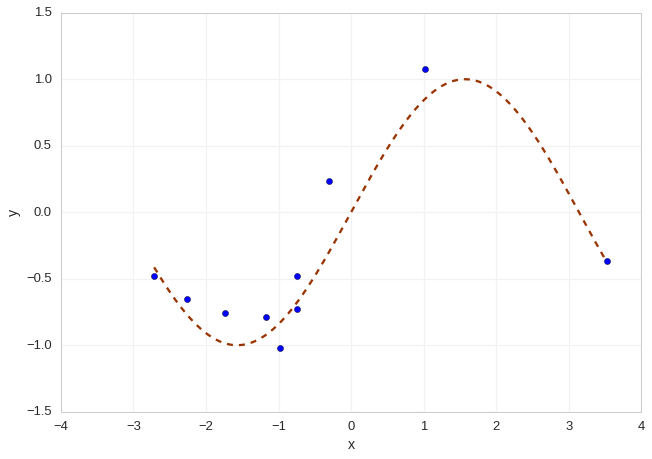

In [6]:
plt.scatter(x, y, 150, marker='.')
plt.plot(xplot, yplot, '--', color='#993300')
plt.xlabel('x')
plt.ylabel('y')

## Fitting with k-nearest neighbors regression

In this case, when we want to estimate the value of a function at $x$ we find the $k$-closest neighbours in the training sample ${x_i}$ and estimate $\hat{y} = \frac{1}{k} \sum_{x_j \in \text{Neighbours}(x; k)} y_j$. Or in words, we estimate the value by taking the average of the $y_j$ values of the k points closest to $x$.

This is straightforward and can be done using `sklearn.neighbors` as follows:

In [7]:
from sklearn import neighbors

In [8]:
k = 3
knn = neighbors.KNeighborsRegressor(k)
y_est = knn.fit(X, y).predict(Xplot)

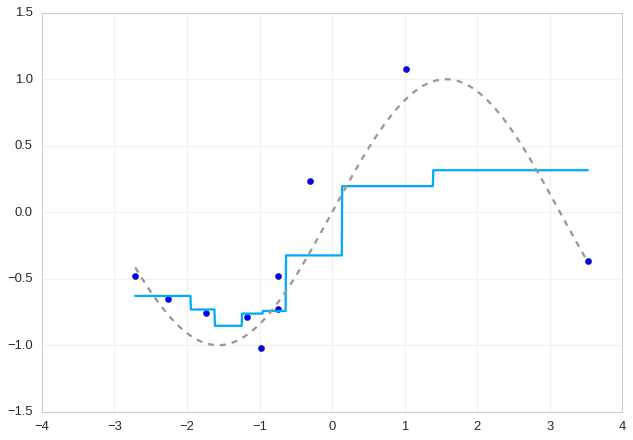

In [9]:
plot_a_fit(x, y, xplot, y_est, include_true=True)

You might (fairly enough!) feel that this is unnecessarily discontinuous - it does not look particularly useful like this. Part of the problem is of course that all points in the neighbourhood has equal weight. Thus one possible modification is to calculate a weighted average where the weights are inversely proportional to the distance between $x_i$ and $x$ (you can also pass in a user defined function, but as we'll discuss shortly it is not clear this is very useful).

To do this you set the weights argument to `KNeighborsRegressor`:

In [10]:
k = 3
knn = neighbors.KNeighborsRegressor(k, weights='distance')
y_est = knn.fit(X, y).predict(Xplot)

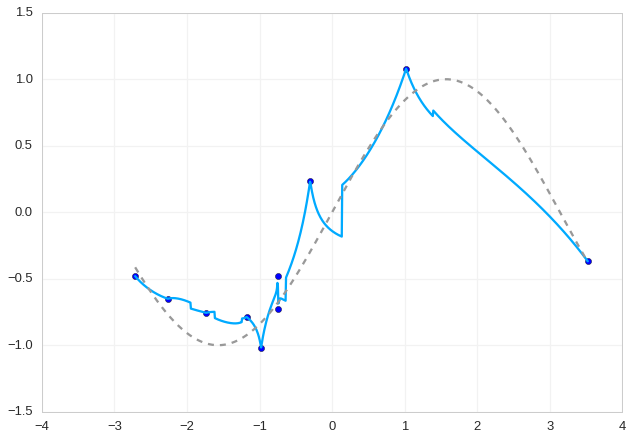

In [11]:
plot_a_fit(x, y, xplot, y_est, include_true=True)

Whether you feel that improved things depends on what you need I guess, but unless you have a lot of points neither of these approaches are really that great - the fundamental discontinuity comes from the fact that the k-nearest neighbourhood is constant until you hit a new training set variable $x_i$. 

So instead we want to use a function that use the neighbouring points but does not give preference to a particular point. This leads us to the so-called Kernel smoothers. 

## Kernel regression

The natural modification of nearest neighbour is to include all points with a weight given by a function known as the *kernel*. Since we calculate a mean with this function as weight, this is known as a kernel-weighted average.

The most widely used version is the so-called Nadaraya-Watson kernel weighted average. This is defined as

$$\hat{y}(x) = \frac{\sum_{i=1}^N K_h\left(x, x_i\right) y_i}{\sum_{i=1}^N K_h\left(x, x_i\right)} $$

where the sums are over the training sample $\{x_i, y_i\}$. The $K_h(\cdot)$ function is a kernel function - just like what we had when we were doing the kernel density estimation.  $h$ here is the band-width of the kernel - for the implementation in Python this is constant but it could also be adjusted by the local density. 

The kernel function can take a range of values like for KDEs. You will mostly see the Gaussian and Epanechnikov kernels but as far as I know the standard implementation in `astroML` does not provide the Epanechnikov kernel, and frankly only the gaussian works well although other kernels should be possible.

In [12]:
from astroML.linear_model import NadarayaWatson

In [13]:
model = NadarayaWatson('gaussian', np.asarray(0.6))
model.fit(X, y)
y_est = model.predict(Xplot)

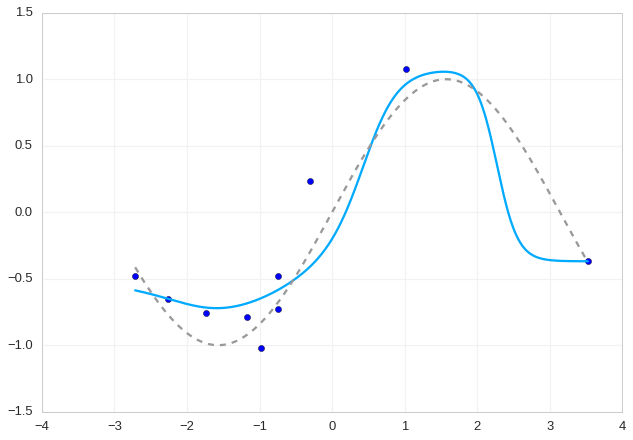

In [14]:
plot_a_fit(x, y, xplot, y_est, include_true=True)

As usual the bandwidth can be estimated using cross-validation. 

This provides a possible smoother - when the band-width goes to small values it approaches the k-nearest regression version with a distance weighted average.

## Locally linear regression

One problem with kernel regression estimate is that it can be severely biased at the edge of the domain. To remove this one can move to locally linear regression. This basically works like kernel regression, but in this case we fit a linear regression model at each output point, weighted by a kernel.

That might sound like a bit of hassle perhaps but it is very powerful. To understand how it works, consider a point $x_0$. We can calculate the distance to each point in our training sample $d_i = |x_0-x_i|$. This is then normalised by the band-width to give the variable

$$t_i = \frac{d_i}{h} $$

the literature sometimes use $\lambda$ for the band-width. Given this $t_i$ we can assign a weight to each point in the training set, $w_i=1/t_i$ could work for instance, except for the fact that it blows up when $x_0$ approaches $x_i$. The standard choice for the locally linear regression method known as the loess/lowess is to use a weight function (or kernel function) called the tri-cube function:

$$w_i = (1-|t_i|^3)^3 \; I(|t| \le 1)$$

where $I(\cdot)$ is the indicator function which is 1 when the argument is true and 0 otherwise. The function then looks like

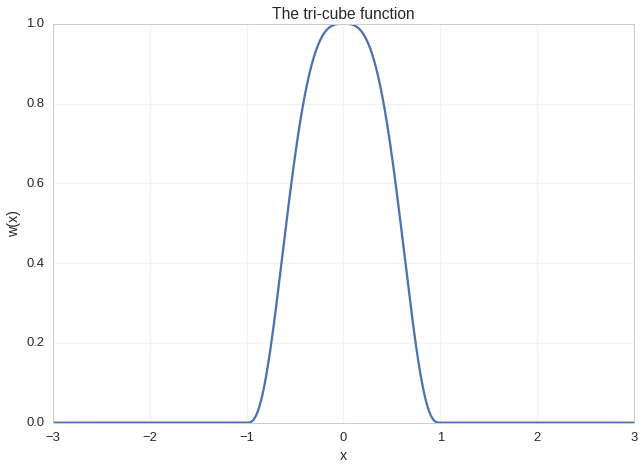

In [15]:
xx = np.linspace(-3,3,1000)
plt.plot(xx, (1-np.abs(xx)**3)**3*(np.abs(xx) <= 1))
plt.xlabel('x')
plt.ylabel('w(x)')
plt.title('The tri-cube function')

An advantage of this function is the fact that it has compact support (only a finite range in $x$ will contribute to the calculation. 

Now, from this discussion it should be clear that the local linear regression is a cool idea. However as Python implementations I am not aware of any that really are regressors (ie. can be used to predict $y$ at arbitrary $x$ values - instead they are smoothers of the data and give predictions at the $x_i$ values of the training set. This is still very useful though! So let us have a look at this and I'll come back to the regressors afterwards.

The packages that exist is `lowess` in `statsmodels` and a separate Cython package called `cylowess` (https://github.com/livingsocial/cylowess - can be installed with pip install cylowess). cylowess seems the better option from my limited use. I will first show the use on the data above.

In [16]:
from statsmodels.nonparametric.smoothers_lowess import lowess as sm_lowess
import cylowess

In [17]:
c_lowess = cylowess.lowess

The two functions have a very similar calling interface and give similar results so I will plot only one:

In [18]:
res_c = c_lowess(y,x)
res_sm = sm_lowess(y, x)

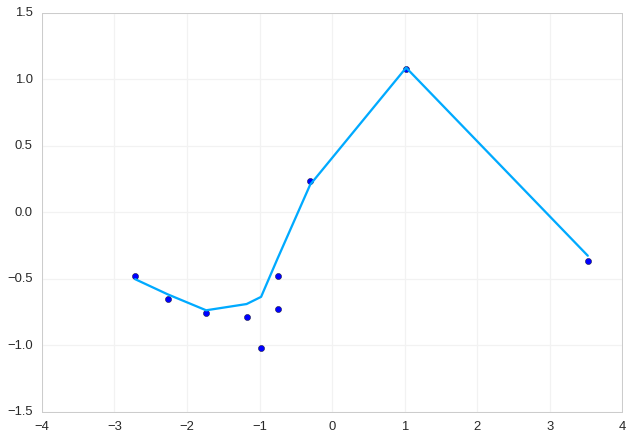

In [19]:
plot_a_fit(x, y, res_c[:, 0], res_c[:, 1])

Ok, that is not that interesting - to really see the advantage of lowess smoothing it is necessary with more points - and noisy ones. So here are some with a lot of noise that is very much not Gaussian. I'll call it here with two different bandwidths (given as frac - the fraction of points to use):

In [20]:
x_noisy = np.random.uniform(low = -2*np.pi, high = 2*np.pi, size=500)
y_noisy = np.sin(x_noisy) + +stats.t.rvs(2.5, size=len(x_noisy))

In [21]:
res_noisy_0p1 = c_lowess(y_noisy, x_noisy, frac=0.1)
res_noisy_0p3 = c_lowess(y_noisy, x_noisy, frac=0.3)

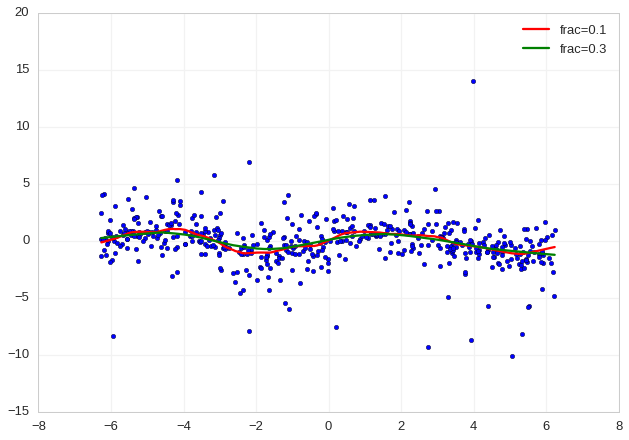

In [22]:
plt.scatter(x_noisy, y_noisy)
plt.plot(res_noisy_0p1[:, 0], res_noisy_0p1[:, 1], 'r-', label='frac=0.1')
plt.plot(res_noisy_0p3[:, 0], res_noisy_0p3[:, 1], 'g-', label='frac=0.3')
plt.legend()

In fact this way to indicate the local trend of the data is so common that the `seaborn` plotting package provides a direct way to do this:

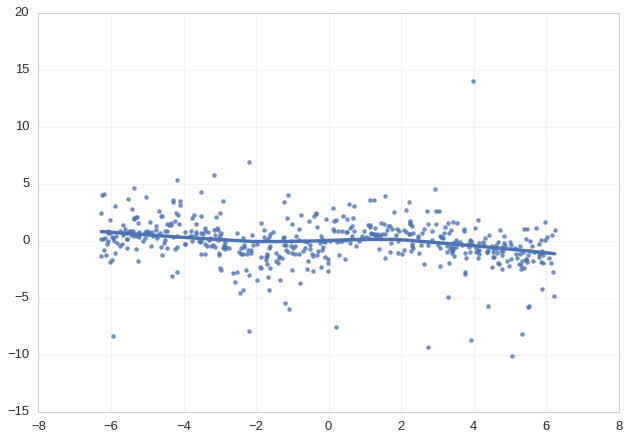

In [23]:
sns.regplot(x_noisy, y_noisy, lowess=True)

Ok, but what if you actually wanted to use this for regression to predict values at other points than your training sample. Well, at the moment you either have to move to R - there is a package called `locfit` in R which is excellent for this kind of work and personally what I use.

Or you can roll your own little code. Try to write this yourself:

Loop over the x_out data. We here do:
1. Calculate the distance to each point and select the N_each closest points (there are fast ways to do this but do not worry about this).
2. Calculate the weight for each point.
3. Run a weighted linear regression
4. Estimate y at this x value.

I would suggest using a Gaussian weighting function and use all points (ie. ignore the frac option in the routines above).

In [24]:
def tricube(t):
    """
    The tricube function
    """
    
    return (1-np.abs(t)**3)**3*(np.abs(t) <= 1)

def jb_local_linreg(x, y, x_out, bandwidth, frac=0.1):
    """
    Calculate a local linear regression from a dataset.    
    """
    
    # The total number of points.
    N = len(x)
    
    # The output array
    y_out = np.empty(len(x_out))
    y_out.fill(np.nan)
    
    # The number of points to consider for each regression.
    N_each = np.ceil(frac*N)
    
    # Loop over the x_out data. We here do:
    #   1. Calculate the distance to each point and select the 
    #      N_each closest points (there are _much_ faster ways to do this!)
    #   2. Calculate the weight for each point.
    #   3. Run a weighted linear regression
    #   4. Estimate y at this x vlaue.
    
    
    for i in range(len(x_out)):
        
        this_xout = x_out[i]
        
        # 1. Calculate the distances and choose the N_each closest
        dist = np.abs(this_xout-x)
        si = np.argsort(dist)
        use = si[0:N_each]
        x_fit = x[use]
        y_fit = y[use]
        
        # 2. Calculate the weights
        t = dist[use]/bandwidth
        weights = np.exp(-dist[use]/(2.0*bandwidth))#tricube(t)
        
        # 3. Run the weighted linear regression - note that some weights
        # might be zero so I will ignore those.
        keep, = np.where(weights > 0)
        if len(keep) > 2:
            x_fit = x_fit[keep]
            y_fit = y_fit[keep]
            weights = weights[keep]
            
            X = sm.add_constant(x_fit)
            mod_wls = sm.WLS(y_fit, X, weights=weights)
            res = mod_wls.fit()
            p = res.params
            y_out[i] = p[0] + p[1]*this_xout

            
    return y_out
            
            
        
    


In [25]:
yplot = jb_local_linreg(x, y, xplot, 0.3, frac=1.0)

/home/daniel/Software/anaconda3/lib/python2.7/site-packages/ipykernel/__main__.py:38: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


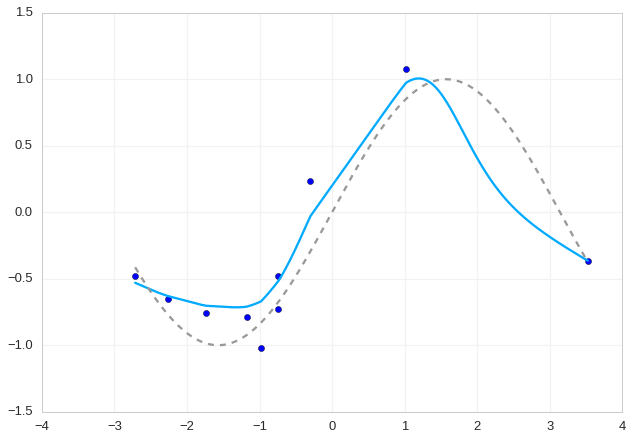

In [26]:
plot_a_fit(x, y, xplot, yplot, include_true=True)